### Exemplo de Esqueleto do Loop de Treinamento:

In [319]:
import os

os.chdir("..")
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [320]:
from learn.toolkit.engine import Value
from learn.toolkit.nn import MLP, Layer, Neuron

from learn.toolkit.utils import (
    to_value_matrix, 
    to_value_vector, 
    forward, 
    update_mlp,
    draw_dot)
from typing import List, Union


In [321]:
# Build a dataset
import numpy as np

xs = np.array([
    [0.1, 0.1, 0.1],
    [0.1, 0.1, 0.1],
    [-0.2, -0.75, -1.0],
    [-0.2, -0.75, -1.0],
])

xs = to_value_matrix(xs)

ys = np.array([1.0, 1.0, 0.0, 0.0])

model = MLP(number_inputs=3, # Numero de festures
            list_number_outputs=[4, 4, 4, 4, 4, 1]) # [num_entradas, ?, num_saidas]


for i in range(50):

    y_pred = [model(x) for x in xs]

    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, y_pred)])

    loss.backward()

    learning_rate = 0.01
    for layer in model.parameters():
        layer.data -= learning_rate * layer.grad

    print(i, round(loss.data, 2))

    model.zero_grad()
    


# Investigar quais os neuronios que mais estão com dificuldade de aprender (sempre com os maiores erros)
# Alterar o learning_rate para diferentes neuronios, (neuronios mais burros (que estão errando muito) aumentar o learning_rate e ir diminuindo conforme eles estão errando menos)

0 2.0
1 1.85
2 1.72
3 1.61
4 1.51
5 1.43
6 1.37
7 1.31
8 1.26
9 1.22
10 1.19
11 1.16
12 1.14
13 1.11
14 1.1
15 1.08
16 1.07
17 1.06
18 1.05
19 1.04
20 1.04
21 1.03
22 1.03
23 1.02
24 1.02
25 1.02
26 1.01
27 1.01
28 1.01
29 1.01
30 1.01
31 1.01
32 1.0
33 1.0
34 1.0
35 1.0
36 1.0
37 1.0
38 1.0
39 1.0
40 1.0
41 1.0
42 1.0
43 1.0
44 1.0
45 1.0
46 1.0
47 1.0
48 1.0
49 1.0


In [322]:
model([-1.0, -1.0, -1.0]) - 0

Value(data=0.4923, label='Calculation Result', grad=0.0000)

In [323]:
for layer in model.parameters():
    layer.data -= learning_rate * layer.grad

    print(layer)

Value(data=0.4394, label='w_n0_i1', grad=0.0000)
Value(data=0.0158, label='w_n0_i2', grad=0.0000)
Value(data=0.3767, label='w_n0_i3', grad=0.0000)
Value(data=0.0000, label='b_n0', grad=0.0000)
Value(data=-0.8650, label='w_n1_i1', grad=0.0000)
Value(data=-0.6310, label='w_n1_i2', grad=0.0000)
Value(data=-0.5106, label='w_n1_i3', grad=0.0000)
Value(data=0.0000, label='b_n1', grad=0.0000)
Value(data=0.9353, label='w_n2_i1', grad=0.0000)
Value(data=-0.6146, label='w_n2_i2', grad=0.0000)
Value(data=-0.4571, label='w_n2_i3', grad=0.0000)
Value(data=0.0000, label='b_n2', grad=0.0000)
Value(data=0.2602, label='w_n3_i1', grad=0.0000)
Value(data=0.6027, label='w_n3_i2', grad=0.0000)
Value(data=-0.5252, label='w_n3_i3', grad=0.0000)
Value(data=0.0000, label='b_n3', grad=0.0000)
Value(data=-0.0498, label='w_n0_i1', grad=0.0000)
Value(data=-0.8555, label='w_n0_i2', grad=0.0000)
Value(data=-0.1202, label='w_n0_i3', grad=0.0000)
Value(data=-0.4459, label='w_n0_i4', grad=0.0000)
Value(data=0.0000, lab

In [324]:
# draw_dot(loss)

In [325]:
import math
import random
from graphviz import Digraph

def draw_mlp_architecture(mlp: MLP, title: str = "Arquitetura da Rede Neural"):
    """
    Desenha a arquitetura de um MLP, mostrando neurônios como círculos e conexões entre camadas.

    Args:
        mlp (MLP): A instância do MLP a ser visualizada.
        title (str): Título do grafo.
    """
    dot = Digraph(comment=title, graph_attr={'rankdir': 'LR', 'splines': 'line', 'nodesep': '0.5', 'ranksep': '1.5'})
    dot.attr(label=title, fontsize='20', labelloc='t') # Título no topo

    # Camada de Entrada
    # O número de entradas para a primeira camada do MLP.
    # A primeira camada é mlp.layers[0].
    # O número de entradas para os neurônios dessa camada é len(neuron.weights).
    num_mlp_inputs = len(mlp.layers[0].neurons[0].weights)
    
    input_nodes_graphviz_ids = []
    with dot.subgraph(name='cluster_input_layer') as c:
        c.attr(label='Camada de Entrada', color='lightgrey', style='filled', rank='source') # 'source' rank
        for i in range(num_mlp_inputs):
            node_id = f'input_{i}'
            input_nodes_graphviz_ids.append(node_id)
            c.node(node_id, f'X{i+1}', shape='circle', style='filled', fillcolor='palegreen', width='0.6', height='0.6', fixedsize='true')

    # Camadas Ocultas e de Saída
    prev_layer_neuron_graphviz_ids = input_nodes_graphviz_ids
    
    for layer_idx, layer in enumerate(mlp.layers):
        layer_label_text = f'Camada Oculta {layer_idx + 1}'
        fill_color = 'lightblue' # Cor padrão para camadas ocultas
        
        if layer_idx == len(mlp.layers) - 1: # Última camada é a de saída
            layer_label_text = 'Camada de Saída'
            fill_color = 'lightgoldenrodyellow'
        elif layer_idx == 0: # Primeira camada processada (pode ser oculta ou de saída se for a única)
             layer_label_text = f'1ª Camada ({("Oculta" if len(mlp.layers) > 1 else "Saída")})'


        current_layer_neuron_graphviz_ids = []
        # Usar 'rank=same' para alinhar neurônios da mesma camada
        with dot.subgraph(name=f'cluster_layer_{layer.layer_id}') as c:
            c.attr(label=layer_label_text, color='lightgrey', style='filled', rank='same')
            for neuron_local_idx, neuron in enumerate(layer.neurons):
                # neuron.neuron_id é o índice local ("0", "1", etc.)
                # layer.layer_id é o ID da camada ("l0", "l1", etc.)
                # Criamos um ID único para o nó no Graphviz
                neuron_graphviz_id = f"{layer.layer_id}_n{neuron.neuron_id}"
                current_layer_neuron_graphviz_ids.append(neuron_graphviz_id)
                
                neuron_display_label = f'N{int(neuron.neuron_id)+1}' # Ex: N1, N2
                c.node(neuron_graphviz_id, neuron_display_label, shape='circle', style='filled', fillcolor=fill_color, width='0.6', height='0.6', fixedsize='true')
                
                # Adiciona arestas da camada anterior para este neurônio
                for prev_neuron_graphviz_id in prev_layer_neuron_graphviz_ids:
                    dot.edge(prev_neuron_graphviz_id, neuron_graphviz_id)
        
        prev_layer_neuron_graphviz_ids = current_layer_neuron_graphviz_ids
        
    return dot


In [326]:
y_pred

[Value(data=0.4916, label='act_n0', grad=-1.0168),
 Value(data=0.4916, label='act_n0', grad=-1.0168),
 Value(data=0.4916, label='act_n0', grad=0.9832),
 Value(data=0.4916, label='act_n0', grad=0.9832)]

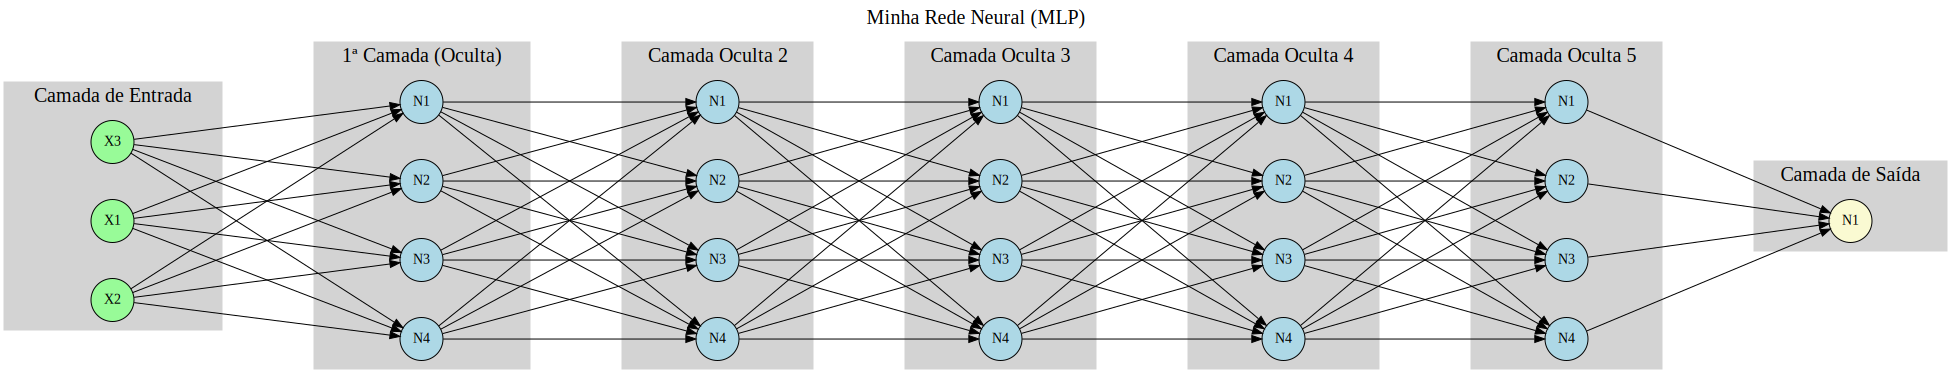

In [327]:
# model = MLP(number_inputs=3, # Numero de festures
#             list_number_outputs=[3, 10, 10, 1]) # [num_entradas, leyer, layer, num_saidas]

dot_graph = draw_mlp_architecture(model, "Minha Rede Neural (MLP)")

# dot_graph.render('arquitetura_mlp_visual', format='svg', cleanup=True)

dot_graph

In [328]:
model.layers[0].neurons[0].neuron_id

'0'

In [ ]:
# x = [2.0, 3.0]
# mlp = MLP(number_inputs=2, list_number_outputs=[3, 3, 1])
# print(mlp)
# out = mlp(x)
# print(f"Output => {out}")

# x = [2.0, 3.0]
# layer = Layer(number_inputs=2, number_outputs=3, name=1)
# print(layer)
# out = layer(x)
# print(f"Output => {out}")
# print()

# x_data = [2.0, 3.0]

# x_data = [Value(x_input, label=f"input {idx}") for idx, x_input in enumerate(x_data, start=1)]
# layer = Layer(number_inputs=2, number_outputs=1, name=1)
# print(layer)
# out = layer(x_data)
# print(f"Output => {out}")

# x_data = [2.0, 3.0]
# x_data = [Value(x_input, label=f"input {idx}") for idx, x_input in enumerate(x_data, start=1)]
# neuron = Neuron(number_inputs=2, name=1)
# print(neuron)
# out = neuron(x_data)
# print(f"Output => {out}")

$\frac{\partial y}{\partial x} = \frac{\partial y}{\partial z} \times \frac{\partial z}{\partial x}$


In [332]:
# draw_dot(model(xs[0]))
# draw_dot(out)

In [341]:
32 * 14

448

In [338]:
# Exemplo de dados "moon" (adaptado de scikit-learn, mas simplificado)
X_data = [
  [1.0, 2.0], [1.5, 1.8], [2.0, 1.0], [2.5, 1.5], [1.2, 0.5], [2.8, 0.8], # Classe A (aprox)
  [3.0, 3.0], [3.5, 2.5], [4.0, 3.5], [4.5, 2.8], [3.2, 4.0], [4.8, 3.2]  # Classe B (aprox)
]

y_data = [1.0]*6 + [-1.0]*6 # Rótulos para SVM loss

X_data_values = to_value_matrix(X_data)
y_data_values = to_value_vector(y_data)

# Converta dados para objetos Value (se seu MLP espera Value como entrada inicial)
# Se o seu MLP lida com floats na primeira camada, isso não é necessário aqui.
# Neste exemplo, vamos assumir que a primeira camada do MLP pode pegar floats.
# No micrograd original, as entradas X são convertidas para Values antes de chamar o MLP.
# X = [[Value(v) for v in x_row] for x_row in X_data]
# ys = [Value(v) for v in y_data]

# --- Configuração do MLP ---
mlp = MLP(number_inputs=2, list_number_outputs=[4, 4, 1]) # 2 entradas, 2 camadas ocultas com 4 neurônios, 1 saída
learning_rate = 0.05
epochs = 100

print(f"Número total de parâmetros: {len(mlp.parameters())}")

def compute_loss(y_true: list[int], y_pred: list["Value"]) -> "Value":
    """
    Calcula a perda média com base na seguinte equação para cada amostra:
    
        loss_i = relu(1 - y_true[i] * y_pred[i])
    
    Ou seja, se y_true[i] * y_pred[i] já satisfaz a margem (≥ 1), a perda será zero;
    caso contrário, a perda será proporcional à violação dessa margem.

    - 1 - true_label * prediction: define a margem que queremos alcançar para que a perda seja zero.
    - relu(): transforma margens negativas em zero, penalizando somente quando a margem não é atingida.
    - Média das perdas: torna o valor final representativo de todas as amostras.
    
    Args:
        y_true (list[int]): Lista de rótulos verdadeiros (+1 ou -1, por exemplo).
        y_pred (list[Value]): Lista das predições (do tipo Value, com autodiferenciação).
    
    Returns:
        Value: A média das perdas calculadas para cada amostra.
    """
    losses = []
    # Itera sobre os pares (rótulo, predição)
    for true_label, prediction in zip(y_true, y_pred):
        # Calcula a margem: 1 - (rótulo * predição)
        margin = Value(1.0, label="compute_loss") - (true_label * prediction)
        # A função ReLU garante que, se o valor da margem for negativo, a perda seja zero
        loss = margin.relu()
        losses.append(loss)

    # Calcula a média das perdas
    average_loss = sum(losses) * (1.0 / len(losses))
    return average_loss


# --- Loop de Treinamento ---
train_feedback = []
for epoch in range(epochs):
    
    """

    O MLP está aprendendo da seguinte forma:
    1, `Tenta` fazer previsões com seus parâmetros atuais.
    2. `Mede` o quão erradas foram suas tentativas (calcula a perda).
    3. `Descobre` como cada um de seus parâmetros internos contribuiu para esse erro específico (calcula os gradientes via backpropagation).
    4. `Ajusta` sutilmente cada parâmetro na direção que deve reduzir o erro no futuro (atualiza os parâmetros usando o gradiente descendente).
    5. `Repete` esse processo muitas vezes (épocas), melhorando gradualmente.    
    """
    # Forward pass & Loss calculation

    total_loss_epoch = 0.0
    y_predictions_epoch = [] # Para guardar as predições da rede (objetos Value)

    y_predictions_epoch = forward(mlp=mlp, x_data=X_data_values)

    # Calcular a perda SVM "max-margin" (exemplo)
    # loss = sum((1 + -yi*scorei).relu() for yi, scorei in zip(ys_values, y_predictions_epoch)) / len(ys_values)
    # Ou uma perda de erro quadrático simples se for regressão ou se os rótulos forem 0/1 e usar sigmoide.
    # Para SVM-like loss:
    # losses = [(Value(1.0) + -y_data[i]*y_predictions_epoch[i]).relu() for i in range(len(y_data))]
    # data_loss = sum(losses) * (1.0 / len(losses)) # Média da perda

    data_loss = compute_loss(y_true=y_data, 
                             y_pred=y_predictions_epoch)

    # Regularização (opcional, mas bom para evitar overfitting)
    # (Regularização L2): Este termo penaliza pesos (p) grandes no mlp. 
    # Adicionar $α∑p^2$ à perda total ajuda a prevenir o overfitting, encorajando o modelo a encontrar soluções mais "simples" (com pesos menores).
    alpha = 1e-4 # Força da regularização
    reg_loss = alpha * sum((p*p for p in mlp.parameters()))
    total_loss = data_loss + reg_loss

    # Backward pass
    mlp.zero_grad()   # Zerar gradientes de todas as execuções anteriores
    total_loss.backward() # Calcular gradientes a partir da perda total

    # Update (Gradiente Descendente)
    update_mlp(mlp=mlp, learning_rate=learning_rate)
    # update_mlp_b(mlp, learning_rate)

    total_loss_epoch = total_loss.data

    accuracy = sum(1 for i in range(len(y_data)) if (y_predictions_epoch[i].data > 0) == (y_data[i] > 0)) / len(y_data)
    if epoch % 5 == 0 or epoch == epochs - 1:
        # Avaliar acurácia (para classificação)
        # Aqui, apenas verificamos se o sinal do score corresponde ao rótulo y_data (-1 ou 1)
        print(f"Epoch {epoch}: Loss = {total_loss_epoch:.4f}, Accuracy = {accuracy*100:.2f}%")

    train_feedback.append({"epoch":epoch, "loss":round(total_loss_epoch, 4), "accuracy":round(accuracy, 2)})
# Após o treinamento, você pode usar mlp(new_x_value) para fazer previsões.
# E visualizar o grafo de 'total_loss' da última época com draw_dot.
# from micrograd.engine import Value # Supondo que Value esteja aqui
# from micrograd.nn import Neuron, Layer, MLP # Supondo que suas classes estejam aqui
# ... seu código de Value, Neuron, Layer, MLP ...
# from graphviz import Digraph # (Se você copiou a função draw_dot)



Número total de parâmetros: 37
Epoch 0: Loss = 1.6261, Accuracy = 50.00%
Epoch 5: Loss = 1.0173, Accuracy = 41.67%
Epoch 10: Loss = 1.0025, Accuracy = 33.33%
Epoch 15: Loss = 0.9899, Accuracy = 50.00%
Epoch 20: Loss = 0.9708, Accuracy = 50.00%
Epoch 25: Loss = 0.9200, Accuracy = 50.00%
Epoch 30: Loss = 0.7867, Accuracy = 50.00%
Epoch 35: Loss = 0.7299, Accuracy = 50.00%
Epoch 40: Loss = 0.7060, Accuracy = 50.00%
Epoch 45: Loss = 0.6847, Accuracy = 50.00%
Epoch 50: Loss = 0.6634, Accuracy = 58.33%
Epoch 55: Loss = 0.6414, Accuracy = 66.67%
Epoch 60: Loss = 0.6183, Accuracy = 66.67%
Epoch 65: Loss = 0.5939, Accuracy = 66.67%
Epoch 70: Loss = 0.5681, Accuracy = 66.67%
Epoch 75: Loss = 0.5404, Accuracy = 66.67%
Epoch 80: Loss = 0.5105, Accuracy = 75.00%
Epoch 85: Loss = 0.4779, Accuracy = 83.33%
Epoch 90: Loss = 0.4441, Accuracy = 83.33%
Epoch 95: Loss = 0.4073, Accuracy = 91.67%
Epoch 99: Loss = 0.3732, Accuracy = 91.67%


In [ ]:
end

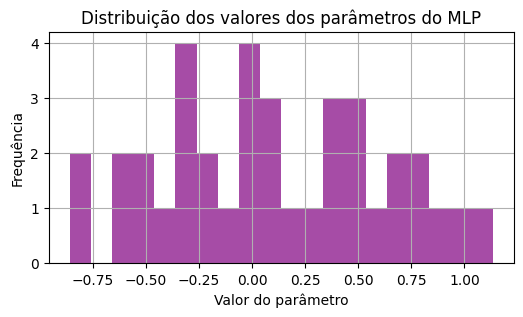

In [334]:
# 1. Distribuição dos valores dos parâmetros (weights e bias) do MLP ao final do treinamento
import matplotlib.pyplot as plt

params = mlp.parameters()
weights = [p.data for p in params]
plt.figure(figsize=(6,3))
plt.hist(weights, bins=20, color='purple', alpha=0.7)
plt.title("Distribuição dos valores dos parâmetros do MLP")
plt.xlabel("Valor do parâmetro")
plt.ylabel("Frequência")
plt.grid(True)
plt.show()

In [ ]:
from collections import Counter

Counter([round(w, 1) for w in weights])

Counter({-0.3: 4,
         0.7: 3,
         0.2: 3,
         0.6: 3,
         0.4: 3,
         0.0: 3,
         -1.0: 2,
         0.3: 2,
         -0.9: 2,
         0.1: 2,
         -0.8: 2,
         -0.5: 1,
         -0.4: 1,
         0.8: 1,
         -0.6: 1,
         1.0: 1,
         -0.7: 1,
         1.1: 1,
         -0.2: 1})

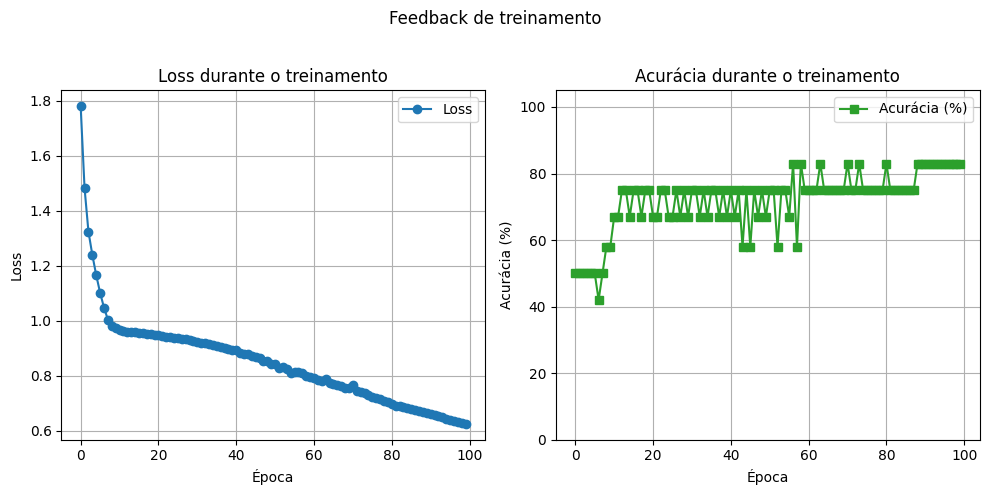

In [335]:
import matplotlib.pyplot as plt


list_epoch = [dict_feedback.get("epoch", 0) for dict_feedback in train_feedback]
list_loss = [dict_feedback.get("loss", 0) for dict_feedback in train_feedback]
list_accuracy = [dict_feedback.get("accuracy", 0) for dict_feedback in train_feedback]

plt.figure(figsize=(10, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(list_epoch, list_loss, marker='o', color='tab:blue', label='Loss')
plt.title("Loss durante o treinamento")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(list_epoch, [a * 100 for a in list_accuracy], marker='s', color='tab:green', label='Acurácia (%)')
plt.title("Acurácia durante o treinamento")
plt.xlabel("Época")
plt.ylabel("Acurácia (%)")
plt.ylim(0, 105)
plt.grid(True)
plt.legend()

plt.suptitle("Feedback de treinamento")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
data_loss

Value(data=0.8283, label='', grad=0.0000)

In [ ]:
# draw_dot(total_loss)

In [ ]:
end

NameError: name 'end' is not defined

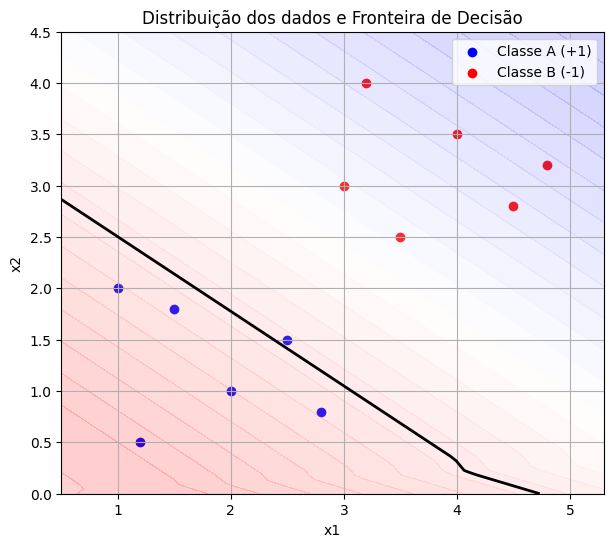

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Melhoria: Função para plotar dados e decisão do MLP

def plot_data_and_decision(X_data, y_data, mlp, resolution=100):

    X_data_A = [X_data[i] for i in range(len(y_data)) if y_data[i] == 1.0]
    X_data_B = [X_data[i] for i in range(len(y_data)) if y_data[i] == -1.0]

    plt.figure(figsize=(7, 6))
    plt.scatter([x[0] for x in X_data_A], [x[1] for x in X_data_A], color='blue', label='Classe A (+1)')
    plt.scatter([x[0] for x in X_data_B], [x[1] for x in X_data_B], color='red', label='Classe B (-1)')

    # Plotar a fronteira de decisão do MLP
    x_min, x_max = min(x[0] for x in X_data) - 0.5, max(x[0] for x in X_data) + 0.5
    y_min, y_max = min(x[1] for x in X_data) - 0.5, max(x[1] for x in X_data) + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution), np.linspace(y_min, y_max, resolution))
    grid = np.c_[xx.ravel(), yy.ravel()]
    zz = np.array([mlp(list(pt)).data for pt in grid])
    zz = zz.reshape(xx.shape)

    plt.contourf(xx, yy, zz, levels=np.linspace(zz.min(), zz.max(), 25), alpha=0.2, cmap='bwr')
    plt.contour(xx, yy, zz, levels=[0], colors='k', linewidths=2)  # Fronteira de decisão

    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Distribuição dos dados e Fronteira de Decisão')
    plt.legend()
    plt.grid(True)
    plt.show()


# Exemplo de dados "moon" (adaptado de scikit-learn, mas simplificado)
X_data = np.array([
  [1.0, 2.0], [1.5, 1.8], [2.0, 1.0], [2.5, 1.5], [1.2, 0.5], [2.8, 0.8], # Classe A (aprox)
  [3.0, 3.0], [3.5, 2.5], [4.0, 3.5], [4.5, 2.8], [3.2, 4.0], [4.8, 3.2]  # Classe B (aprox)
])
y_data = [1.0]*6 + [-1.0]*6 # Rótulos para SVM loss

plot_data_and_decision(X_data, y_data, mlp)

In [ ]:

# Exemplo para visualizar o grafo da última perda calculada:
# (Certifique-se que total_loss é um objeto Value)
g = draw_dot(total_loss)
g.render('mlp_loss_graph', view=True) # Salva como mlp_loss_graph.svg (ou .pdf) e tenta abrir

'mlp_loss_graph.svg'

---

Dataset iris

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Carregar o dataset
iris = load_iris()
X, y = iris.data, iris.target

# Pré-processamento: Padronizar as features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

# Se seu MLP espera y como one-hot encoding para multiclasse:
# (Assumindo que n_classes = 3 para o Iris dataset)
# y_train_one_hot = np.eye(len(np.unique(y_train)))[y_train]
# y_test_one_hot = np.eye(len(np.unique(y_test)))[y_test]

print(f"Formato de X_train: {X_train.shape}")
print(f"Formato de y_train: {y_train.shape}")
# print(f"Formato de y_train_one_hot: {y_train_one_hot.shape}") # Se usar one-hot

#X_train
#y_train

Formato de X_train: (105, 4)
Formato de y_train: (105,)


In [ ]:
X_train[0]

array([-0.90068117, -1.28296331, -0.4308277 , -0.13075464])

In [ ]:
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

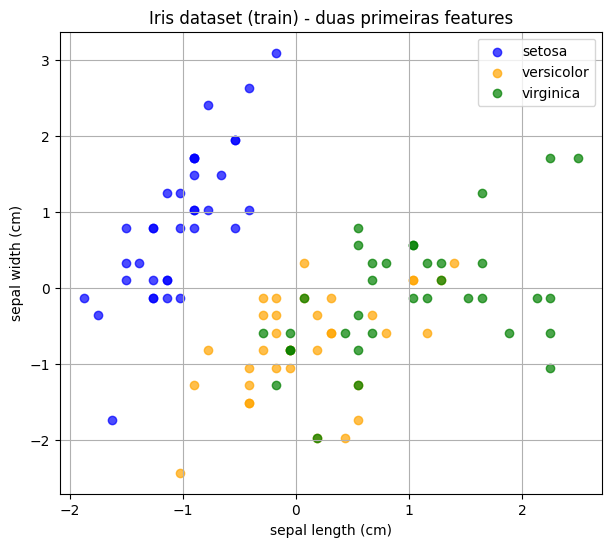

In [ ]:
import matplotlib.pyplot as plt

# Vamos plotar as duas primeiras features do conjunto de treino do iris
plt.figure(figsize=(7, 6))
for label, color, name in zip([0, 1, 2], ['blue', 'orange', 'green'], iris.target_names):
    idx = y_train == label
    plt.scatter(X_train[idx, 0], X_train[idx, 1], label=name, color=color, alpha=0.7)

plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.title('Iris dataset (train) - duas primeiras features')
plt.legend()
plt.grid(True)
plt.show()